In [3]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [4]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [62]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS002',
    'date' :          '2024-08-19',
    'expnum' :         [1,2,3,4]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21]),
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 8,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : True,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : False,
    'gpu_reg' : True,
}

In [63]:

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

In [64]:
# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4 already exists
Loading job directory for SS002_2024-08-19_1-2-3-4 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [65]:
job.params['fix_fastZ'] = False

   Saved a copy of params at /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/SS002/2024-08-19/2/2024-08-19_2_SS002_2P_00001_00012.tif
    Loaded file into shared memory in 17.97 sec
    Workers completed in 3.94 sec
    Total time: 21.92 sec
      Loading /mnt/zortex-subjects/SS002/2024-08-19/2/2024-08-19_2_SS002_2P_00001_00051.tif
    Loaded file into shared memory in 16.42 sec
    Workers completed in 4.67 sec
    Total time: 21.09 sec
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00019.tif
    Loaded file into shared memory in 16.05 sec
    Workers completed in 5.25 sec
    Total time: 21.30 sec
      Loading /mnt/zortex-subjects/SS002/2024-08-19/4/2024-08-19_4_SS002_2P_00001_00003.tif
    Loaded file into shared memory in 16.59 sec
    Worker

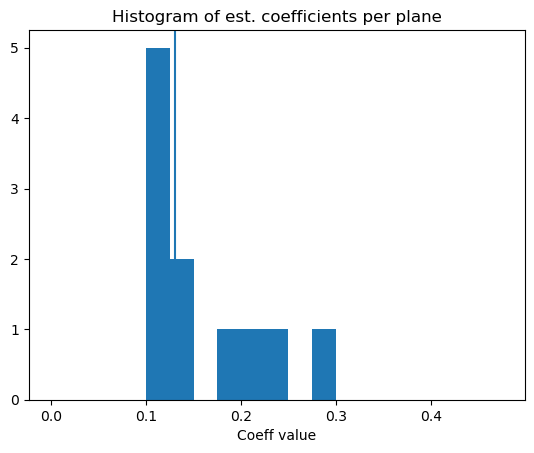

MovieWriter ffmpeg unavailable; using Pillow instead.


   Subtracting with estimated coefficient 0.130
         Subtracting plane 0 from 13
         Subtracting plane 1 from 14
         Subtracting plane 2 from 15
         Subtracting plane 3 from 16
         Subtracting plane 4 from 17
         Subtracting plane 5 from 18
         Subtracting plane 6 from 19
         Subtracting plane 7 from 20
         Subtracting plane 8 from 21
         Subtracting plane 9 from 22
         Subtracting plane 10 from 23
   Using 2d registration
            Loaded mov and masks to GPU for rigid reg in 1.64 sec
            Allocating memory for shifted movie
            GPU RAM: 8 blocks allocated, 4.24 / 9.21 GB used
            Registering plane 0
            Shifting plane 0
            Registering plane 1
            Shifting plane 1
            Registering plane 2
            Shifting plane 2
            Registering plane 3
            Shifting plane 3
            Registering plane 4
            Shifting plane 4
            Registering plane 5
       

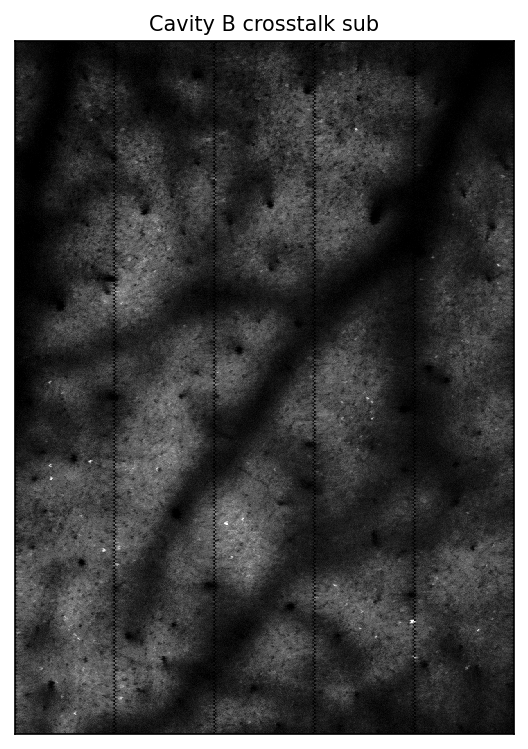

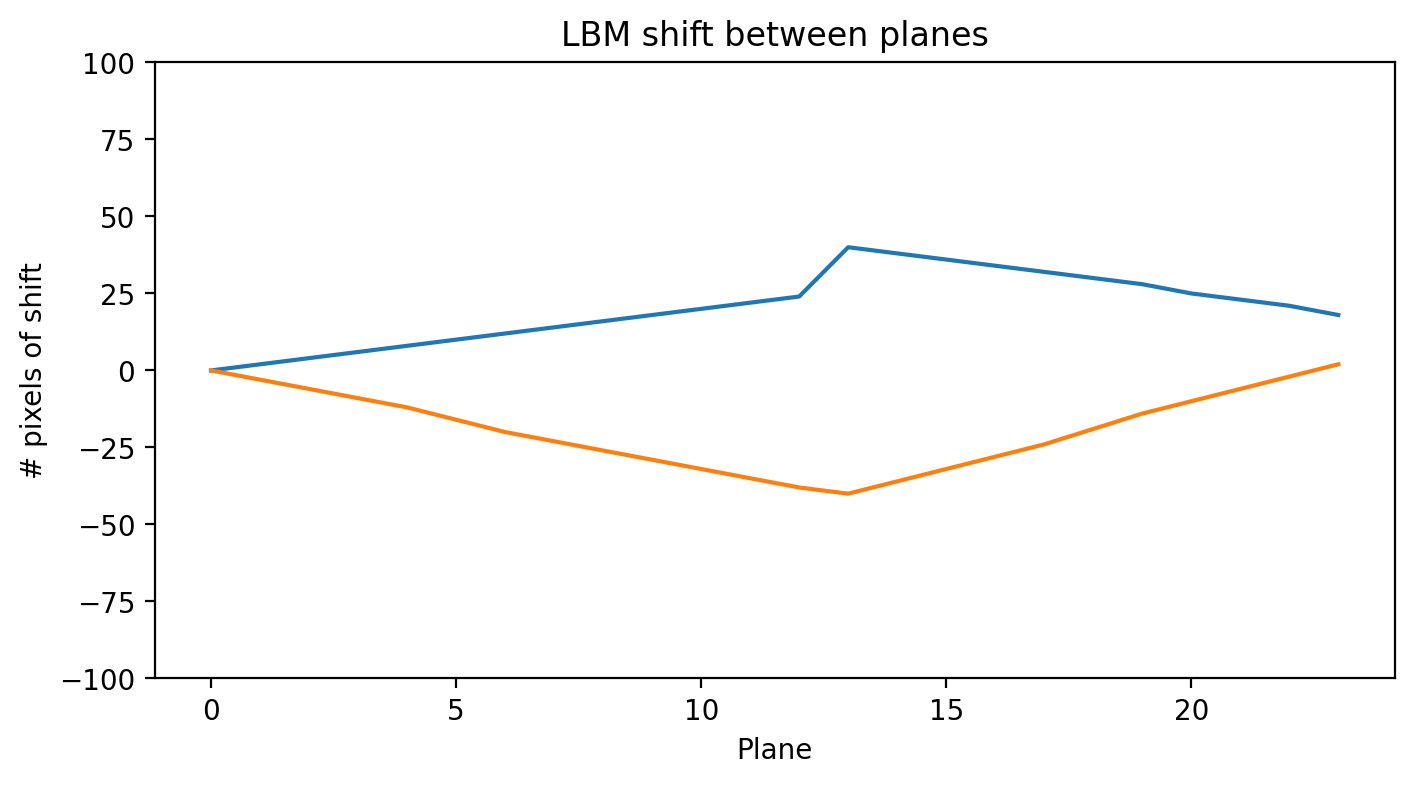

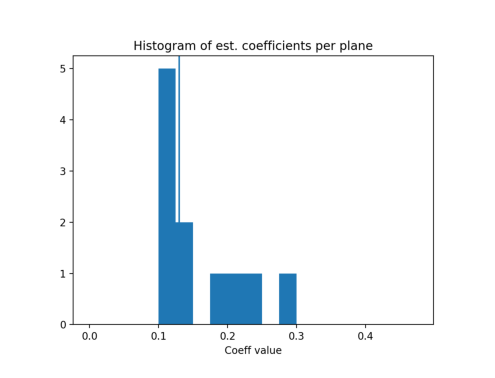

In [66]:
%%time
summary = job.run_init_pass()

In [67]:
summary = job.load_summary()

In [68]:
img = summary['ref_img_3d']

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f28bf4cc430>)

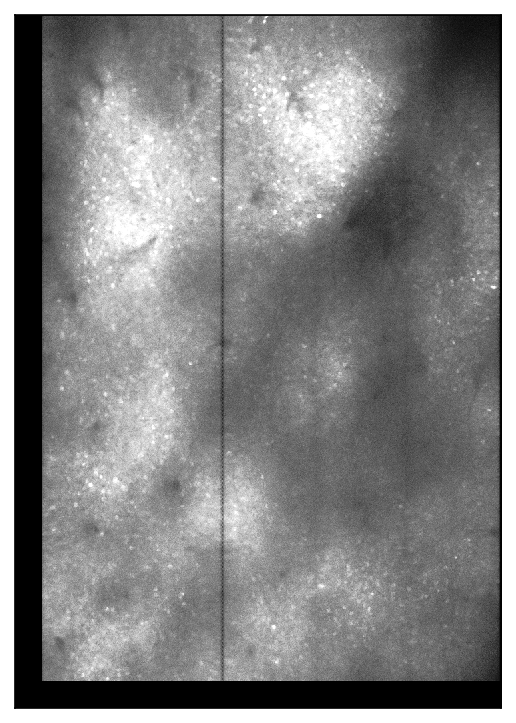

In [69]:
tfu.show_tif(img[0])

In [70]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [71]:
%%time
job.register()

      Found dir /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/registered_fused_data
   Updated main params file
   Starting registration: 3D: False, GPU: True
   Overriding fuse shift value to 8
Will analyze 196 tifs in 196 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 206.819 GB, Virtual Available: 312.062 GB, Virtual Used: 191.133 GB, Swap Used: 015.686 GB
Loading Batch 0 of 195
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00001.tif
    Loaded file into shared memory in 11.41 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.85 sec
    Total time: 16.26 sec
   Loaded 1 files, total 3.22 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 210.089 GB, Virtual Available: 308.792 GB, Virtual Used: 194.403 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 213.313 GB, Virtual Available: 305.568 GB, Virtual Used: 197.627 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 206.387 GB, Virtual Available: 312.494 GB, Virtual Used: 190.702 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 206.387 GB, Virtual Available: 312.494 GB, Virtual Used: 190.702 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00002.tif
         Registered batch in 0.03 sec
         Shifted batch in 0.16 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 4.68 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 5.08 sec
    Total time: 22.55 sec
         Non rigid transformed (on CPU) in 2.21 sec
         After GPU Batch:    Total Used: 219.558 GB, Virtual Available: 299.323 GB, Virtual Used: 203.872 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.54 sec
         After GPU Batch:    Total Used: 218.278 GB, Virtual Available: 300.603 GB, Virtual Used: 202.593 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.89 sec
         After GPU Batch:    Total Used: 240.260 GB, Virtual Available: 278.621 GB, Virtual Used: 224.575 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.53 sec
    Total time: 25.31 sec
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.38 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 228.698 GB, Virtual Available: 290.184 GB, Virtual Used: 213.012 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.32 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.34 sec
    Total time: 23.87 sec
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 226.538 GB, Virtual Available: 292.343 GB, Virtual Used: 210.853 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.56 sec
         After GPU Batch:    Total Used: 225.021 GB, Virtual Available: 293.860 GB, Virtual Used: 209.335 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.28 sec
         Shifted batch in 3.15 sec
         Freeing all blocks
         Completed rigid registration in 5.96 sec
         Computed non-rigid shifts in 6.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.29 sec
    Total time: 25.62 sec
         Non rigid transformed (on CPU) in 1.79 sec
         After GPU Batch:    Total Used: 227.830 GB, Virtual Available: 291.052 GB, Virtual Used: 212.144 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.58 sec
         After GPU Batch:    Total Used: 223.876 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.14 sec
    Total time: 23.75 sec
         Non rigid transformed (on CPU) in 7.06 sec
         After GPU Batch:    Total Used: 227.603 GB, Virtual Available: 291.278 GB, Virtual Used: 211.917 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 225.068 GB, Virtual Available: 293.813 GB, Virtual Used: 209.383 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.29 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.14 sec
    Total time: 28.53 sec
         Non rigid transformed (on CPU) in 7.03 sec
         After GPU Batch:    Total Used: 230.671 GB, Virtual Available: 288.210 GB, Virtual Used: 214.985 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 230.647 GB, Virtual Available: 288.234 GB, Virtual Used: 214.961 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 1040, 730) to /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/registered_fused_data/fused_reg_data0005.npy
   Loaded 1 files, total 3.22 GB
         Saved in 3.23 sec
         After full batch saving:Total Used: 217.103 GB, Virtual Available: 301.778 GB, Virtual Used: 201.418 GB, Swap Used: 015.686 GB
         Memory at batch 6.  Total Used: 217.103 GB, Virtual Available: 301.778 GB, Virtual Used: 201.418 GB, Swap Used: 015.686 GB
Loading Batch 6 of 195
   Batch 6 IO thread joined
         Memory after IO thread 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.69 sec
    Total time: 39.07 sec
   Loaded 1 files, total 3.22 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 216.970 GB, Virtual Available: 301.911 GB, Virtual Used: 201.284 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 216.964 GB, Virtual Available: 301.917 GB, Virtual Used: 201.279 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 213.742 GB, Virtual Available: 305.139 GB, Virtual Used: 198.057 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 213.742 GB, Virtual Available: 305.139 GB, Virtual Used: 198.057 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.10 sec
    Total time: 38.73 sec
   Loaded 1 files, total 3.22 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 216.968 GB, Virtual Available: 301.914 GB, Virtual Used: 201.282 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 216.968 GB, Virtual Available: 301.913 GB, Virtual Used: 201.282 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 213.746 GB, Virtual Available: 305.136 GB, Virtual Used: 198.060 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 213.746 GB, Virtual Available: 305.136 GB, Virtual Used: 198.060 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00010.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.95 sec
         After GPU Batch:    Total Used: 238.516 GB, Virtual Available: 280.365 GB, Virtual Used: 222.831 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.29 sec
    Total time: 24.73 sec
         Registered batch in 0.04 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.58 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.54 sec
         After GPU Batch:    Total Used: 229.668 GB, Virtual Available: 289.213 GB, Virtual Used: 213.982 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.03 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.01 sec
    Total time: 100.03 sec
   Loaded 1 files, total 3.22 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 217.233 GB, Virtual Available: 301.648 GB, Virtual Used: 201.548 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.232 GB, Virtual Available: 301.650 GB, Virtual Used: 201.546 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.002 GB, Virtual Available: 304.879 GB, Virtual Used: 198.317 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.002 GB, Virtual Available: 304.879 GB, Virtual Used: 198.317 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.04 sec
    Total time: 89.00 sec
   Loaded 1 files, total 3.22 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 216.973 GB, Virtual Available: 301.908 GB, Virtual Used: 201.287 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 216.962 GB, Virtual Available: 301.919 GB, Virtual Used: 201.276 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 213.741 GB, Virtual Available: 305.140 GB, Virtual Used: 198.056 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 213.741 GB, Virtual Available: 305.140 GB, Virtual Used: 198.056 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00013.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.26 sec
    Total time: 100.61 sec
   Loaded 1 files, total 3.22 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 217.004 GB, Virtual Available: 301.877 GB, Virtual Used: 201.319 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.010 GB, Virtual Available: 301.872 GB, Virtual Used: 201.324 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 213.784 GB, Virtual Available: 305.097 GB, Virtual Used: 198.098 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00014.tif
         After IO thread launch:Total Used: 213.784 GB, Virtual Available: 305.097 GB, Virtual Used: 198.098 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.39 sec
    Total time: 60.32 sec
   Loaded 1 files, total 3.22 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 217.087 GB, Virtual Available: 301.794 GB, Virtual Used: 201.402 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.094 GB, Virtual Available: 301.787 GB, Virtual Used: 201.409 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 213.869 GB, Virtual Available: 305.012 GB, Virtual Used: 198.184 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 213.869 GB, Virtual Available: 305.012 GB, Virtual Used: 198.184 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.55 sec
    Total time: 24.69 sec
         Non rigid transformed (on CPU) in 7.54 sec
         After GPU Batch:    Total Used: 234.227 GB, Virtual Available: 284.654 GB, Virtual Used: 218.542 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.17 sec
         Computed non-rigid shifts in 1.85 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.86 sec
         After GPU Batch:    Total Used: 223.831 GB, Virtual Available: 295.050 GB, Virtual Used: 208.145 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.65 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.17 sec
    Total time: 24.01 sec
         Non rigid transformed (on CPU) in 7.00 sec
         After GPU Batch:    Total Used: 234.380 GB, Virtual Available: 284.501 GB, Virtual Used: 218.694 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 224.198 GB, Virtual Available: 294.683 GB, Virtual Used: 208.513 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 11.31 sec
   Loaded 1 files, t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.93 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 5.91 sec
    Total time: 23.27 sec
         Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 226.485 GB, Virtual Available: 292.396 GB, Virtual Used: 210.800 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.16 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.49 sec
         After GPU Batch:    Total Used: 225.718 GB, Virtual Available: 293.163 GB, Virtual Used: 210.032 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.28 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.25 sec
    Total time: 26.12 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 227.265 GB, Virtual Available: 291.616 GB, Virtual Used: 211.579 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 4.40 sec
         After GPU Batch:    Total Used: 225.892 GB, Virtual Available: 292.990 GB, Virtual Used: 210.206 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 225.896

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 6.04 sec
    Workers completed in 6.33 sec
    Total time: 25.24 sec
         Computed non-rigid shifts in 6.58 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 228.246 GB, Virtual Available: 290.635 GB, Virtual Used: 212.560 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.16 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.51 sec
         After GPU Batch:    Total Used: 224.014 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.96 sec
         After GPU Batch:    Total Used: 238.569 GB, Virtual Available: 280.312 GB, Virtual Used: 222.883 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.41 sec
    Total time: 24.62 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 4.06 sec
         Computed non-rigid shifts in 4.99 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.16 sec
         After GPU Batch:    Total Used: 226.138 GB, Virtual Available: 292.743 GB, Virtual Used: 210.452 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.28 sec
    Total time: 24.37 sec
         Non rigid transformed (on CPU) in 6.96 sec
         After GPU Batch:    Total Used: 234.607 GB, Virtual Available: 284.274 GB, Virtual Used: 218.922 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 230.054 GB, Virtual Available: 288.827 GB, Virtual Used: 214.368 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.63 sec
         After GPU Batch:    Total Used: 238.498 GB, Virtual Available: 280.383 GB, Virtual Used: 222.813 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.11 sec
    Total time: 24.31 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.45 sec
         Computed non-rigid shifts in 2.12 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.99 sec
         After GPU Batch:    Total Used: 223.248 GB, Virtual Available: 295.633 GB, Virtual Used: 207.562 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 8.37 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.77 sec
         After GPU Batch:    Total Used: 238.761 GB, Virtual Available: 280.120 GB, Virtual Used: 223.075 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.22 sec
    Total time: 24.50 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.21 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.35 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 229.794 GB, Virtual Available: 289.087 GB, Virtual Used: 214.109 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.33 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.08 sec
    Total time: 23.81 sec
         Non rigid transformed (on CPU) in 6.83 sec
         After GPU Batch:    Total Used: 234.128 GB, Virtual Available: 284.753 GB, Virtual Used: 218.442 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.34 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.84 sec
         After GPU Batch:    Total Used: 229.183 GB, Virtual Available: 289.698 GB, Virtual Used: 213.497 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.44 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.03 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.18 sec
    Total time: 23.50 sec
         Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 226.207 GB, Virtual Available: 292.674 GB, Virtual Used: 210.521 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.16 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.55 sec
         After GPU Batch:    Total Used: 225.629 GB, Virtual Available: 293.252 GB, Virtual Used: 209.944 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.24 sec
    Total time: 24.06 sec
         Non rigid transformed (on CPU) in 7.03 sec
         After GPU Batch:    Total Used: 234.057 GB, Virtual Available: 284.824 GB, Virtual Used: 218.371 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 3.86 sec
         Computed non-rigid shifts in 4.66 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 5.71 sec
         After GPU Batch:    Total Used: 223.113 GB, Virtual Available: 295.769 GB, Virtual Used: 207.427 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.04 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.59 sec
         Shifted batch in 3.63 sec
         Freeing all blocks
    Workers completed in 6.24 sec
    Total time: 25.36 sec
         Completed rigid registration in 7.51 sec
         Computed non-rigid shifts in 8.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.65 sec
         After GPU Batch:    Total Used: 229.826 GB, Virtual Available: 289.055 GB, Virtual Used: 214.141 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.37 sec
         Freeing all blocks
         Completed rigid registration in 2.44 sec
         Computed non-rigid shifts in 3.12 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 7.86 sec
         After GPU Batch:    Total Used: 223.858 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.89 sec
    Workers completed in 4.75 sec
    Total time: 12.35 sec
         Computed non-rigid shifts in 5.45 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.58 sec
         After GPU Batch:    Total Used: 218.439 GB, Virtual Available: 300.442 GB, Virtual Used: 202.754 GB, Swap Used: 015.686 GB
         Sending frames 40-50 to GPU for rigid registration
   Loaded 1 files, total 1.45 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.23 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.20 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 218.757 GB, Virtual Available: 300.124 GB, Virtual Used: 203.071 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.33 sec
    Total time: 22.36 sec
   Loaded 1 files, total 3.22 GB
   Batch 28 IO thread joined
         Memory after IO thread joinTotal Used: 211.843 GB, Virtual Available: 307.038 GB, Virtual Used: 196.158 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 213.622 GB, Virtual Available: 305.259 GB, Virtual Used: 197.936 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 210.390 GB, Virtual Available: 308.491 GB, Virtual Used: 194.705 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 210.390 GB, Virtual Available: 308.491 GB, Virtual Used: 194.705 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/2/2024-08-19_2_SS002_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.15 sec
         After GPU Batch:    Total Used: 229.996 GB, Virtual Available: 288.885 GB, Virtual Used: 214.311 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 5.78 sec
    Total time: 24.10 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.83 sec
         Computed non-rigid shifts in 3.33 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.52 sec
         After GPU Batch:    Total Used: 220.635 GB, Virtual Available: 298.246 GB, Virtual Used: 204.949 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.68 sec
         Shifted batch in 1.03 sec
         Freeing all blocks
    Workers completed in 6.01 sec
    Total time: 24.46 sec
         Completed rigid registration in 7.08 sec
         Computed non-rigid shifts in 7.59 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 230.655 GB, Virtual Available: 288.227 GB, Virtual Used: 214.969 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 224.477 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.47 sec
    Total time: 24.84 sec
         Completed rigid registration in 6.84 sec
         Computed non-rigid shifts in 7.59 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 230.335 GB, Virtual Available: 288.546 GB, Virtual Used: 214.649 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 224.531 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.42 sec
    Total time: 24.28 sec
         Non rigid transformed (on CPU) in 7.46 sec
         After GPU Batch:    Total Used: 234.190 GB, Virtual Available: 284.691 GB, Virtual Used: 218.505 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 224.289 GB, Virtual Available: 294.592 GB, Virtual Used: 208.604 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 8.75 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.17 sec
    Total time: 57.99 sec
   Loaded 1 files, total 3.22 GB
   Batch 33 IO thread joined
         Memory after IO thread joinTotal Used: 217.538 GB, Virtual Available: 301.343 GB, Virtual Used: 201.853 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.529 GB, Virtual Available: 301.353 GB, Virtual Used: 201.843 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.306 GB, Virtual Available: 304.576 GB, Virtual Used: 198.620 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.306 GB, Virtual Available: 304.576 GB, Virtual Used: 198.620 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/SS002/2024-08-19/2/2024-08-19_2_SS002_2P_00001_00007.tif
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.17 sec
         Shifted batch in 1.37 sec
         Freeing all blocks
    Workers completed in 6.54 sec
    Total time: 28.03 sec
         Completed rigid registration in 7.51 sec
         Computed non-rigid shifts in 8.03 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 231.438 GB, Virtual Available: 287.443 GB, Virtual Used: 215.752 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 231.440 GB, Virtual Available: 287.441 GB, Virtual Used: 215.754 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (24, 100, 1040, 730) to /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/registered_fused_data/fused_reg_data0033.npy
   Loaded 1 files, total 3.22 GB
         Saved in 4.29 sec
         After full batch saving:Total Used: 217.966 GB, Virtual Availab

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.20 sec
    Total time: 23.90 sec
         Non rigid transformed (on CPU) in 7.48 sec
         After GPU Batch:    Total Used: 227.046 GB, Virtual Available: 291.836 GB, Virtual Used: 211.360 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 11.68 sec
         Computed non-rigid shifts in 12.45 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.71 sec
         After GPU Batch:    Total Used: 223.647 GB, Virtual Available: 295.235 GB, Virtual Used: 207.961 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registratio

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.14 sec
    Total time: 24.24 sec
         Non rigid transformed (on CPU) in 6.98 sec
         After GPU Batch:    Total Used: 234.149 GB, Virtual Available: 284.732 GB, Virtual Used: 218.464 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.48 sec
         After GPU Batch:    Total Used: 224.777 GB, Virtual Available: 294.104 GB, Virtual Used: 209.091 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.08 sec
    Total time: 23.90 sec
         Non rigid transformed (on CPU) in 7.18 sec
         After GPU Batch:    Total Used: 227.459 GB, Virtual Available: 291.422 GB, Virtual Used: 211.774 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 8.09 sec
         Computed non-rigid shifts in 8.70 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.80 sec
         After GPU Batch:    Total Used: 224.147 GB, Virtual Available: 294.734 GB, Virtual Used: 208.461 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.04 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.27 sec
    Total time: 24.59 sec
         Non rigid transformed (on CPU) in 7.31 sec
         After GPU Batch:    Total Used: 234.785 GB, Virtual Available: 284.097 GB, Virtual Used: 219.099 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 4.02 sec
         Computed non-rigid shifts in 4.82 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.38 sec
         After GPU Batch:    Total Used: 226.695 GB, Virtual Available: 292.186 GB, Virtual Used: 211.009 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.20 sec
    Total time: 24.42 sec
         Non rigid transformed (on CPU) in 7.18 sec
         After GPU Batch:    Total Used: 234.923 GB, Virtual Available: 283.958 GB, Virtual Used: 219.238 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 4.78 sec
         Computed non-rigid shifts in 5.63 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 8.50 sec
         After GPU Batch:    Total Used: 226.295 GB, Virtual Available: 292.586 GB, Virtual Used: 210.609 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.22 sec
    Total time: 23.97 sec
         Non rigid transformed (on CPU) in 7.19 sec
         After GPU Batch:    Total Used: 227.208 GB, Virtual Available: 291.673 GB, Virtual Used: 211.523 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.87 sec
         Computed non-rigid shifts in 2.50 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 5.96 sec
         After GPU Batch:    Total Used: 225.850 GB, Virtual Available: 293.031 GB, Virtual Used: 210.165 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.26 sec
    Total time: 23.85 sec
         Non rigid transformed (on CPU) in 1.91 sec
         After GPU Batch:    Total Used: 227.401 GB, Virtual Available: 291.480 GB, Virtual Used: 211.716 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 4.32 sec
         After GPU Batch:    Total Used: 226.222 GB, Virtual Available: 292.659 GB, Virtual Used: 210.537 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.81 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.01 sec
    Total time: 23.57 sec
         Non rigid transformed (on CPU) in 2.42 sec
         After GPU Batch:    Total Used: 227.638 GB, Virtual Available: 291.244 GB, Virtual Used: 211.952 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.59 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.42 sec
         After GPU Batch:    Total Used: 225.757 GB, Virtual Available: 293.124 GB, Virtual Used: 210.071 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.23 sec
    Total time: 24.03 sec
         Non rigid transformed (on CPU) in 7.56 sec
         After GPU Batch:    Total Used: 227.569 GB, Virtual Available: 291.312 GB, Virtual Used: 211.884 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 3.20 sec
         Computed non-rigid shifts in 4.08 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 8.73 sec
         After GPU Batch:    Total Used: 227.071 GB, Virtual Available: 291.811 GB, Virtual Used: 211.385 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.95 sec
         After GPU Batch:    Total Used: 236.337 GB, Virtual Available: 282.545 GB, Virtual Used: 220.651 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.31 sec
    Total time: 24.90 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 11.23 sec
         Computed non-rigid shifts in 11.92 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 6.16 sec
         After GPU Batch:    Total Used: 225.916 GB, Virtual Available: 292.965 GB, Virtual Used: 210.231 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.42 sec
         Freeing all blocks
         Completed rigid registratio

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.85 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.02 sec
    Total time: 23.32 sec
         Non rigid transformed (on CPU) in 2.42 sec
         After GPU Batch:    Total Used: 227.810 GB, Virtual Available: 291.071 GB, Virtual Used: 212.125 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.99 sec
         Computed non-rigid shifts in 1.62 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.77 sec
         After GPU Batch:    Total Used: 225.728 GB, Virtual Available: 293.153 GB, Virtual Used: 210.042 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.15 sec
    Total time: 23.79 sec
         Non rigid transformed (on CPU) in 7.24 sec
         After GPU Batch:    Total Used: 227.574 GB, Virtual Available: 291.307 GB, Virtual Used: 211.888 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.60 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.73 sec
         After GPU Batch:    Total Used: 225.631 GB, Virtual Available: 293.250 GB, Virtual Used: 209.946 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.23 sec
    Total time: 25.25 sec
         Completed rigid registration in 7.00 sec
         Computed non-rigid shifts in 7.53 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 230.787 GB, Virtual Available: 288.094 GB, Virtual Used: 215.102 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.29 sec
         Freeing all blocks
         Completed rigid registration in 2.76 sec
         Computed non-rigid shifts in 3.40 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 3.23 sec
         After GPU Batch:    Total Used: 224.802 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.69 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.19 sec
    Total time: 23.77 sec
         Non rigid transformed (on CPU) in 3.22 sec
         After GPU Batch:    Total Used: 228.151 GB, Virtual Available: 290.730 GB, Virtual Used: 212.466 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.15 sec
         Computed non-rigid shifts in 1.76 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.79 sec
         After GPU Batch:    Total Used: 226.592 GB, Virtual Available: 292.289 GB, Virtual Used: 210.907 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.19 sec
    Total time: 24.29 sec
         Non rigid transformed (on CPU) in 7.30 sec
         After GPU Batch:    Total Used: 227.598 GB, Virtual Available: 291.283 GB, Virtual Used: 211.913 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.57 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.04 sec
         After GPU Batch:    Total Used: 224.939 GB, Virtual Available: 293.942 GB, Virtual Used: 209.253 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.21 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 7.03 sec
         After GPU Batch:    Total Used: 238.869 GB, Virtual Available: 280.012 GB, Virtual Used: 223.184 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
    Workers completed in 6.24 sec
    Total time: 24.77 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.26 sec
         Computed non-rigid shifts in 1.78 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.44 sec
         After GPU Batch:    Total Used: 224.422 GB, Virtual Available: 294.459 GB, Virtual Used: 208.737 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.28 sec
    Total time: 24.40 sec
         Non rigid transformed (on CPU) in 7.21 sec
         After GPU Batch:    Total Used: 235.128 GB, Virtual Available: 283.753 GB, Virtual Used: 219.442 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.19 sec
         Computed non-rigid shifts in 1.84 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.51 sec
         After GPU Batch:    Total Used: 224.956 GB, Virtual Available: 293.925 GB, Virtual Used: 209.270 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.44 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.25 sec
    Total time: 24.93 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 6.91 sec
         Computed non-rigid shifts in 7.42 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 230.734 GB, Virtual Available: 288.147 GB, Virtual Used: 215.049 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 224.991 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.17 sec
    Total time: 23.84 sec
         Non rigid transformed (on CPU) in 3.30 sec
         After GPU Batch:    Total Used: 228.159 GB, Virtual Available: 290.722 GB, Virtual Used: 212.473 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.93 sec
         Computed non-rigid shifts in 1.55 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.83 sec
         After GPU Batch:    Total Used: 226.393 GB, Virtual Available: 292.488 GB, Virtual Used: 210.708 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.95 sec
    Total time: 24.75 sec
         Non rigid transformed (on CPU) in 8.37 sec
         After GPU Batch:    Total Used: 227.790 GB, Virtual Available: 291.091 GB, Virtual Used: 212.105 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.61 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.80 sec
         After GPU Batch:    Total Used: 225.386 GB, Virtual Available: 293.495 GB, Virtual Used: 209.701 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 3.72 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.03 sec
    Total time: 24.24 sec
         Non rigid transformed (on CPU) in 7.06 sec
         After GPU Batch:    Total Used: 235.723 GB, Virtual Available: 283.158 GB, Virtual Used: 220.037 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.51 sec
         After GPU Batch:    Total Used: 225.731 GB, Virtual Available: 293.150 GB, Virtual Used: 210.045 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 6.88 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.90 sec
    Total time: 23.40 sec
         Non rigid transformed (on CPU) in 7.25 sec
         After GPU Batch:    Total Used: 229.548 GB, Virtual Available: 289.333 GB, Virtual Used: 213.863 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.61 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.79 sec
         After GPU Batch:    Total Used: 227.737 GB, Virtual Available: 291.144 GB, Virtual Used: 212.051 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.20 sec
    Total time: 24.13 sec
         Non rigid transformed (on CPU) in 7.58 sec
         After GPU Batch:    Total Used: 227.399 GB, Virtual Available: 291.482 GB, Virtual Used: 211.714 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.99 sec
         Computed non-rigid shifts in 1.65 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.85 sec
         After GPU Batch:    Total Used: 225.775 GB, Virtual Available: 293.106 GB, Virtual Used: 210.090 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.03 sec
    Total time: 23.90 sec
         Non rigid transformed (on CPU) in 7.30 sec
         After GPU Batch:    Total Used: 228.431 GB, Virtual Available: 290.451 GB, Virtual Used: 212.745 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.09 sec
         Computed non-rigid shifts in 1.76 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.86 sec
         After GPU Batch:    Total Used: 226.950 GB, Virtual Available: 291.931 GB, Virtual Used: 211.264 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.45 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.12 sec
    Total time: 23.78 sec
         Non rigid transformed (on CPU) in 7.47 sec
         After GPU Batch:    Total Used: 227.790 GB, Virtual Available: 291.091 GB, Virtual Used: 212.104 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.92 sec
         Computed non-rigid shifts in 1.55 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.98 sec
         After GPU Batch:    Total Used: 226.170 GB, Virtual Available: 292.712 GB, Virtual Used: 210.484 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.44 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.03 sec
    Total time: 24.00 sec
         Non rigid transformed (on CPU) in 7.17 sec
         After GPU Batch:    Total Used: 228.234 GB, Virtual Available: 290.647 GB, Virtual Used: 212.548 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.98 sec
         Computed non-rigid shifts in 1.67 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 225.691 GB, Virtual Available: 293.190 GB, Virtual Used: 210.006 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 8.79 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.98 sec
    Total time: 23.48 sec
         Non rigid transformed (on CPU) in 7.52 sec
         After GPU Batch:    Total Used: 228.158 GB, Virtual Available: 290.723 GB, Virtual Used: 212.472 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.14 sec
         After GPU Batch:    Total Used: 226.440 GB, Virtual Available: 292.441 GB, Virtual Used: 210.754 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.98 sec
         After GPU Batch:    Total Used: 238.084 GB, Virtual Available: 280.797 GB, Virtual Used: 222.399 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 6.26 sec
    Total time: 27.13 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.20 sec
         Computed non-rigid shifts in 1.71 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 232.105 GB, Virtual Available: 286.776 GB, Virtual Used: 216.419 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 232.089 GB, Virtual Available: 286.792 GB, Virtual Used: 216.403 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.12 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 5.61 sec
    Total time: 22.96 sec
         Non rigid transformed (on CPU) in 3.02 sec
         After GPU Batch:    Total Used: 228.243 GB, Virtual Available: 290.638 GB, Virtual Used: 212.557 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.99 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.19 sec
         After GPU Batch:    Total Used: 226.741 GB, Virtual Available: 292.140 GB, Virtual Used: 211.056 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.07 sec
    Total time: 22.96 sec
         Completed rigid registration in 6.71 sec
         Computed non-rigid shifts in 7.46 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 229.954 GB, Virtual Available: 288.928 GB, Virtual Used: 214.268 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 224.528 GB, Virtual Available: 294.353 GB, Virtual Used: 208.843 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.39 sec
         Shifted batch in 0.97 sec
         Freeing all blocks
    Workers completed in 6.58 sec
    Total time: 23.31 sec
         Completed rigid registration in 7.34 sec
         Computed non-rigid shifts in 7.92 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 230.115 GB, Virtual Available: 288.766 GB, Virtual Used: 214.430 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.70 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 224.414 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.22 sec
    Total time: 22.68 sec
         Completed rigid registration in 6.82 sec
         Computed non-rigid shifts in 7.38 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 230.086 GB, Virtual Available: 288.795 GB, Virtual Used: 214.401 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 224.387 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 7.26 sec
    Total time: 23.10 sec
         Non rigid transformed (on CPU) in 8.56 sec
         After GPU Batch:    Total Used: 230.715 GB, Virtual Available: 288.166 GB, Virtual Used: 215.030 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.58 sec
         After GPU Batch:    Total Used: 224.626 GB, Virtual Available: 294.255 GB, Virtual Used: 208.940 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 4.75 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.20 sec
    Total time: 23.65 sec
         Non rigid transformed (on CPU) in 7.53 sec
         After GPU Batch:    Total Used: 227.344 GB, Virtual Available: 291.537 GB, Virtual Used: 211.659 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.89 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.82 sec
         After GPU Batch:    Total Used: 225.591 GB, Virtual Available: 293.290 GB, Virtual Used: 209.905 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.43 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.95 sec
    Total time: 23.67 sec
         Non rigid transformed (on CPU) in 7.12 sec
         After GPU Batch:    Total Used: 228.273 GB, Virtual Available: 290.608 GB, Virtual Used: 212.587 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.15 sec
         After GPU Batch:    Total Used: 226.538 GB, Virtual Available: 292.344 GB, Virtual Used: 210.852 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.37 sec
         Freeing all blocks
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.29 sec
         Shifted batch in 0.15 sec
         Freeing all blocks
    Workers completed in 5.87 sec
    Total time: 22.24 sec
         Completed rigid registration in 6.71 sec
         Computed non-rigid shifts in 7.23 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 229.822 GB, Virtual Available: 289.059 GB, Virtual Used: 214.136 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 223.708 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.01 sec
         Shifted batch in 2.75 sec
         Freeing all blocks
    Workers completed in 5.87 sec
    Total time: 22.79 sec
         Completed rigid registration in 7.58 sec
         Computed non-rigid shifts in 8.28 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.49 sec
         After GPU Batch:    Total Used: 229.855 GB, Virtual Available: 289.026 GB, Virtual Used: 214.169 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.63 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 3.01 sec
         After GPU Batch:    Total Used: 224.062 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.58 sec
         Shifted batch in 1.41 sec
         Freeing all blocks
         Completed rigid registration in 5.58 sec
    Workers completed in 6.05 sec
    Total time: 22.98 sec
         Computed non-rigid shifts in 7.65 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.69 sec
         After GPU Batch:    Total Used: 229.351 GB, Virtual Available: 289.530 GB, Virtual Used: 213.666 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.64 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 7.97 sec
         After GPU Batch:    Total Used: 223.603 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.83 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.06 sec
    Total time: 23.46 sec
         Non rigid transformed (on CPU) in 1.89 sec
         After GPU Batch:    Total Used: 226.891 GB, Virtual Available: 291.990 GB, Virtual Used: 211.206 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.50 sec
         After GPU Batch:    Total Used: 225.815 GB, Virtual Available: 293.066 GB, Virtual Used: 210.130 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.91 sec
    Total time: 21.87 sec
         Non rigid transformed (on CPU) in 6.96 sec
         After GPU Batch:    Total Used: 233.879 GB, Virtual Available: 285.002 GB, Virtual Used: 218.194 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.95 sec
         Computed non-rigid shifts in 3.53 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 7.79 sec
         After GPU Batch:    Total Used: 224.912 GB, Virtual Available: 293.970 GB, Virtual Used: 209.226 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.65 sec
         Shifted batch in 0.47 sec
         Freeing all blocks
         Completed rigid registration in 5.49 sec
    Workers completed in 6.04 sec
    Total time: 22.65 sec
         Computed non-rigid shifts in 8.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.60 sec
         After GPU Batch:    Total Used: 229.148 GB, Virtual Available: 289.733 GB, Virtual Used: 213.462 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.27 sec
         Computed non-rigid shifts in 2.00 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.94 sec
         After GPU Batch:    Total Used: 223.707 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.77 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.13 sec
    Total time: 23.53 sec
         Non rigid transformed (on CPU) in 2.88 sec
         After GPU Batch:    Total Used: 227.547 GB, Virtual Available: 291.334 GB, Virtual Used: 211.861 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 10.91 sec
         Computed non-rigid shifts in 11.76 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 3.57 sec
         After GPU Batch:    Total Used: 223.721 GB, Virtual Available: 295.160 GB, Virtual Used: 208.036 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.00 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.21 sec
    Total time: 24.28 sec
         Non rigid transformed (on CPU) in 2.00 sec
         After GPU Batch:    Total Used: 227.300 GB, Virtual Available: 291.581 GB, Virtual Used: 211.615 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.56 sec
         After GPU Batch:    Total Used: 225.962 GB, Virtual Available: 292.919 GB, Virtual Used: 210.276 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.22 sec
         Shifted batch in 2.95 sec
         Freeing all blocks
         Completed rigid registration in 5.71 sec
         Computed non-rigid shifts in 6.26 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.03 sec
    Total time: 23.05 sec
         Non rigid transformed (on CPU) in 1.62 sec
         After GPU Batch:    Total Used: 227.709 GB, Virtual Available: 291.172 GB, Virtual Used: 212.023 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 7.01 sec
         After GPU Batch:    Total Used: 226.172 GB, Virtual Available: 292.709 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 6.22 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.07 sec
    Total time: 23.49 sec
         Non rigid transformed (on CPU) in 2.18 sec
         After GPU Batch:    Total Used: 227.527 GB, Virtual Available: 291.354 GB, Virtual Used: 211.841 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.98 sec
         Computed non-rigid shifts in 1.64 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.73 sec
         After GPU Batch:    Total Used: 225.338 GB, Virtual Available: 293.543 GB, Virtual Used: 209.652 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
      

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.30 sec
         Shifted batch in 1.11 sec
         Freeing all blocks
         Completed rigid registration in 5.64 sec
    Workers completed in 6.17 sec
    Total time: 22.88 sec
         Computed non-rigid shifts in 7.03 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.76 sec
         After GPU Batch:    Total Used: 228.884 GB, Virtual Available: 289.997 GB, Virtual Used: 213.199 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.00 sec
         Computed non-rigid shifts in 1.81 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.08 sec
         After GPU Batch:    Total Used: 223.832 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 2.06 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.90 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.36 sec
    Total time: 23.59 sec
         Non rigid transformed (on CPU) in 2.33 sec
         After GPU Batch:    Total Used: 227.131 GB, Virtual Available: 291.750 GB, Virtual Used: 211.446 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.60 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.13 sec
         After GPU Batch:    Total Used: 225.375 GB, Virtual Available: 293.506 GB, Virtual Used: 209.689 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
      

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.95 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.22 sec
    Total time: 23.81 sec
         Non rigid transformed (on CPU) in 2.26 sec
         After GPU Batch:    Total Used: 227.117 GB, Virtual Available: 291.764 GB, Virtual Used: 211.432 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.44 sec
         Freeing all blocks
         Completed rigid registration in 3.92 sec
         Computed non-rigid shifts in 4.61 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 3.24 sec
         After GPU Batch:    Total Used: 223.768 GB, Virtual Available: 295.113 GB, Virtual Used: 208.083 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.62 sec
         Shifted batch in 1.43 sec
         Freeing all blocks
         Completed rigid registration in 5.82 sec
    Workers completed in 6.00 sec
    Total time: 22.77 sec
         Computed non-rigid shifts in 7.68 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.55 sec
         After GPU Batch:    Total Used: 229.237 GB, Virtual Available: 289.645 GB, Virtual Used: 213.551 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.03 sec
         Computed non-rigid shifts in 1.72 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 8.12 sec
         After GPU Batch:    Total Used: 226.699 GB, Virtual Available: 292.183 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.34 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Computed non-rigid shifts in 6.45 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 5.92 sec
    Total time: 22.88 sec
         Non rigid transformed (on CPU) in 1.61 sec
         After GPU Batch:    Total Used: 228.099 GB, Virtual Available: 290.783 GB, Virtual Used: 212.413 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 4.84 sec
         After GPU Batch:    Total Used: 226.799 GB, Virtual Available: 292.082 GB, Virtual Used: 211.114 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 3.41 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Computed non-rigid shifts in 5.66 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 5.86 sec
    Total time: 22.98 sec
         Non rigid transformed (on CPU) in 2.26 sec
         After GPU Batch:    Total Used: 227.550 GB, Virtual Available: 291.332 GB, Virtual Used: 211.864 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.99 sec
         Computed non-rigid shifts in 1.64 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.93 sec
         After GPU Batch:    Total Used: 225.748 GB, Virtual Available: 293.134 GB, Virtual Used: 210.062 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
      

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 5.96 sec
    Total time: 22.63 sec
         Completed rigid registration in 6.90 sec
         Computed non-rigid shifts in 7.57 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.74 sec
         After GPU Batch:    Total Used: 229.824 GB, Virtual Available: 289.057 GB, Virtual Used: 214.139 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.20 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.24 sec
         Computed non-rigid shifts in 1.91 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.97 sec
         After GPU Batch:    Total Used: 223.614 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 5.35 sec
         Computed non-rigid shifts in 6.42 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 5.89 sec
    Total time: 22.93 sec
         Non rigid transformed (on CPU) in 1.62 sec
         After GPU Batch:    Total Used: 228.253 GB, Virtual Available: 290.629 GB, Virtual Used: 212.567 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 5.37 sec
         After GPU Batch:    Total Used: 226.936 GB, Virtual Available: 291.946 GB, Virtual Used: 211.250 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.45 sec
         Shifted batch in 3.22 sec
         Freeing all blocks
         Completed rigid registration in 6.43 sec
    Workers completed in 6.09 sec
    Total time: 22.86 sec
         Computed non-rigid shifts in 7.45 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 229.173 GB, Virtual Available: 289.709 GB, Virtual Used: 213.487 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.80 sec
         Computed non-rigid shifts in 1.32 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 223.729 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.98 sec
    Workers completed in 6.19 sec
    Total time: 23.16 sec
         Computed non-rigid shifts in 7.90 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 229.681 GB, Virtual Available: 289.200 GB, Virtual Used: 213.996 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 223.948 GB, Virtual Available: 294.933 GB, Virtual Used: 208.262 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.32 sec
    Total time: 23.42 sec
         Computed non-rigid shifts in 7.14 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.95 sec
         After GPU Batch:    Total Used: 228.515 GB, Virtual Available: 290.366 GB, Virtual Used: 212.830 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.21 sec
         Freeing all blocks
         Completed rigid registration in 0.94 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.59 sec
         After GPU Batch:    Total Used: 226.911 GB, Virtual Available: 291.970 GB, Virtual Used: 211.225 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 6.45 sec
    Workers completed in 6.17 sec
    Total time: 23.17 sec
         Computed non-rigid shifts in 7.42 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 228.961 GB, Virtual Available: 289.920 GB, Virtual Used: 213.276 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 223.983 GB, Virtual Available: 294.899 GB, Virtual Used: 208.297 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 2.05 sec
         Shifted batch in 2.66 sec
         Freeing all blocks
    Workers completed in 6.30 sec
    Total time: 23.00 sec
         Completed rigid registration in 7.06 sec
         Computed non-rigid shifts in 7.73 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 229.557 GB, Virtual Available: 289.324 GB, Virtual Used: 213.871 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 223.795 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.99 sec
    Workers completed in 6.16 sec
    Total time: 23.20 sec
         Computed non-rigid shifts in 7.31 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 228.948 GB, Virtual Available: 289.934 GB, Virtual Used: 213.262 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.26 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.58 sec
         After GPU Batch:    Total Used: 224.065 GB, Virtual Available: 294.816 GB, Virtual Used: 208.380 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.92 sec
         After GPU Batch:    Total Used: 236.220 GB, Virtual Available: 282.661 GB, Virtual Used: 220.535 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.22 sec
    Total time: 22.44 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.85 sec
         Computed non-rigid shifts in 2.47 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.64 sec
         After GPU Batch:    Total Used: 223.395 GB, Virtual Available: 295.486 GB, Virtual Used: 207.710 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.48 sec
         Shifted batch in 3.25 sec
         Freeing all blocks
         Completed rigid registration in 5.99 sec
    Workers completed in 5.93 sec
    Total time: 22.87 sec
         Computed non-rigid shifts in 6.54 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.89 sec
         After GPU Batch:    Total Used: 228.366 GB, Virtual Available: 290.515 GB, Virtual Used: 212.681 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.51 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 4.11 sec
         After GPU Batch:    Total Used: 226.436 GB, Virtual Available: 292.446 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.12 sec
    Total time: 22.25 sec
         Non rigid transformed (on CPU) in 7.04 sec
         After GPU Batch:    Total Used: 233.923 GB, Virtual Available: 284.958 GB, Virtual Used: 218.238 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.20 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.21 sec
         After GPU Batch:    Total Used: 229.934 GB, Virtual Available: 288.947 GB, Virtual Used: 214.248 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.27 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.11 sec
         Shifted batch in 0.93 sec
         Freeing all blocks
    Workers completed in 6.11 sec
    Total time: 22.75 sec
         Completed rigid registration in 6.73 sec
         Computed non-rigid shifts in 7.41 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 229.762 GB, Virtual Available: 289.119 GB, Virtual Used: 214.077 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.74 sec
         Computed non-rigid shifts in 1.26 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 224.087 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 4.61 sec
    Workers completed in 4.60 sec
    Total time: 14.74 sec
         Computed non-rigid shifts in 5.20 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.51 sec
         After GPU Batch:    Total Used: 223.969 GB, Virtual Available: 294.912 GB, Virtual Used: 208.284 GB, Swap Used: 015.686 GB
         Sending frames 50-60 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
   Loaded 1 files, total 1.93 GB
         Computed non-rigid shifts in 1.37 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.78 sec
         After GPU Batch:    Total Used: 220.763 GB, Virtual Available: 298.118 GB, Virtual Used: 205.078 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.29 sec
    Total time: 22.35 sec
   Loaded 1 files, total 3.22 GB
   Batch 99 IO thread joined
         Memory after IO thread joinTotal Used: 213.841 GB, Virtual Available: 305.041 GB, Virtual Used: 198.155 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 215.123 GB, Virtual Available: 303.758 GB, Virtual Used: 199.437 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 211.903 GB, Virtual Available: 306.978 GB, Virtual Used: 196.218 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 211.903 GB, Virtual Available: 306.978 GB, Virtual Used: 196.218 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.54 sec
         Shifted batch in 0.92 sec
         Freeing all blocks
    Workers completed in 5.99 sec
    Total time: 22.79 sec
         Completed rigid registration in 6.79 sec
         Computed non-rigid shifts in 7.31 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 227.188 GB, Virtual Available: 291.694 GB, Virtual Used: 211.502 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.28 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-rigid shifts in 1.38 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 221.140 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.20 sec
    Total time: 23.12 sec
         Completed rigid registration in 7.81 sec
         Computed non-rigid shifts in 8.39 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 230.454 GB, Virtual Available: 288.427 GB, Virtual Used: 214.768 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.09 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.80 sec
         Computed non-rigid shifts in 1.31 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 224.327 GB, Virtual Available: 294.554 GB, Virtual Used: 208.641 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 1.44 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.04 sec
    Total time: 23.11 sec
         Computed non-rigid shifts in 6.91 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.96 sec
         After GPU Batch:    Total Used: 228.395 GB, Virtual Available: 290.486 GB, Virtual Used: 212.710 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.70 sec
         After GPU Batch:    Total Used: 223.702 GB, Virtual Available: 295.180 GB, Virtual Used: 208.016 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.14 sec
         Shifted batch in 3.36 sec
         Freeing all blocks
    Workers completed in 5.57 sec
    Total time: 22.46 sec
         Completed rigid registration in 6.63 sec
         Computed non-rigid shifts in 7.15 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 230.261 GB, Virtual Available: 288.620 GB, Virtual Used: 214.575 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 224.176 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.38 sec
         Shifted batch in 0.66 sec
         Freeing all blocks
    Workers completed in 6.19 sec
    Total time: 22.70 sec
         Completed rigid registration in 7.01 sec
         Computed non-rigid shifts in 7.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 229.674 GB, Virtual Available: 289.207 GB, Virtual Used: 213.989 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 223.832 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.11 sec
    Total time: 24.27 sec
         Non rigid transformed (on CPU) in 7.21 sec
         After GPU Batch:    Total Used: 233.593 GB, Virtual Available: 285.288 GB, Virtual Used: 217.907 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.40 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.02 sec
         After GPU Batch:    Total Used: 224.342 GB, Virtual Available: 294.539 GB, Virtual Used: 208.657 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 9.54 sec
   Loaded 1 files, to

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.93 sec
         Shifted batch in 1.07 sec
         Freeing all blocks
         Completed rigid registration in 5.81 sec
    Workers completed in 5.87 sec
    Total time: 22.67 sec
         Computed non-rigid shifts in 6.36 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 228.250 GB, Virtual Available: 290.631 GB, Virtual Used: 212.564 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 4.76 sec
         After GPU Batch:    Total Used: 226.684 GB, Virtual Available: 292.197 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 5.78 sec
    Workers completed in 6.02 sec
    Total time: 22.37 sec
         Computed non-rigid shifts in 10.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.23 sec
         After GPU Batch:    Total Used: 229.432 GB, Virtual Available: 289.449 GB, Virtual Used: 213.747 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
         Computed non-rigid shifts in 1.29 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 223.806 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.16 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.25 sec
    Total time: 23.56 sec
         Non rigid transformed (on CPU) in 3.46 sec
         After GPU Batch:    Total Used: 227.601 GB, Virtual Available: 291.280 GB, Virtual Used: 211.916 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.56 sec
         After GPU Batch:    Total Used: 226.089 GB, Virtual Available: 292.792 GB, Virtual Used: 210.404 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.39 sec
         Shifted batch in 0.71 sec
         Freeing all blocks
    Workers completed in 6.01 sec
    Total time: 22.61 sec
         Completed rigid registration in 6.85 sec
         Computed non-rigid shifts in 7.38 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 229.650 GB, Virtual Available: 289.231 GB, Virtual Used: 213.965 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 223.922 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.36 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.03 sec
    Total time: 23.49 sec
         Non rigid transformed (on CPU) in 2.97 sec
         After GPU Batch:    Total Used: 227.347 GB, Virtual Available: 291.534 GB, Virtual Used: 211.662 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.60 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 4.11 sec
         After GPU Batch:    Total Used: 225.141 GB, Virtual Available: 293.740 GB, Virtual Used: 209.455 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
      

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.72 sec
         Shifted batch in 2.77 sec
         Freeing all blocks
    Workers completed in 5.67 sec
    Total time: 22.59 sec
         Completed rigid registration in 9.03 sec
         Computed non-rigid shifts in 9.67 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.63 sec
         After GPU Batch:    Total Used: 230.123 GB, Virtual Available: 288.758 GB, Virtual Used: 214.438 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.25 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.26 sec
         Computed non-rigid shifts in 1.93 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 6.88 sec
         After GPU Batch:    Total Used: 224.008 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.70 sec
         After GPU Batch:    Total Used: 234.665 GB, Virtual Available: 284.217 GB, Virtual Used: 218.979 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.07 sec
    Total time: 22.51 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.19 sec
         Computed non-rigid shifts in 2.69 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 229.726 GB, Virtual Available: 289.155 GB, Virtual Used: 214.041 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.37 sec
         Shifted batch in 3.17 sec
         Freeing all blocks
    Workers completed in 6.20 sec
    Total time: 22.97 sec
         Completed rigid registration in 7.28 sec
         Computed non-rigid shifts in 7.80 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 229.846 GB, Virtual Available: 289.035 GB, Virtual Used: 214.160 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 224.018 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.18 sec
    Total time: 22.95 sec
         Completed rigid registration in 8.39 sec
         Computed non-rigid shifts in 8.92 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 229.652 GB, Virtual Available: 289.229 GB, Virtual Used: 213.967 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 223.828 GB, Virtual Available: 295.053 GB, Virtual Used: 208.143 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.42 sec
         Shifted batch in 3.22 sec
         Freeing all blocks
         Completed rigid registration in 6.02 sec
    Workers completed in 6.02 sec
    Total time: 22.85 sec
         Computed non-rigid shifts in 8.74 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.30 sec
         After GPU Batch:    Total Used: 229.515 GB, Virtual Available: 289.366 GB, Virtual Used: 213.830 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 223.801 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 6.33 sec
    Workers completed in 6.26 sec
    Total time: 23.26 sec
         Computed non-rigid shifts in 9.27 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 229.939 GB, Virtual Available: 288.942 GB, Virtual Used: 214.254 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 224.220 GB, Virtual Available: 294.661 GB, Virtual Used: 208.534 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.53 sec
         After GPU Batch:    Total Used: 240.879 GB, Virtual Available: 278.002 GB, Virtual Used: 225.194 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.25 sec
    Total time: 22.49 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.44 sec
         Computed non-rigid shifts in 1.95 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 229.791 GB, Virtual Available: 289.090 GB, Virtual Used: 214.105 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.80 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 2.19 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.14 sec
    Total time: 22.85 sec
         Computed non-rigid shifts in 7.35 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 229.540 GB, Virtual Available: 289.341 GB, Virtual Used: 213.854 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 224.628 GB, Virtual Available: 294.254 GB, Virtual Used: 208.942 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.95 sec
    Workers completed in 6.48 sec
    Total time: 24.57 sec
         After GPU Batch:    Total Used: 235.249 GB, Virtual Available: 283.632 GB, Virtual Used: 219.564 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.08 sec
         Computed non-rigid shifts in 1.59 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.60 sec
         After GPU Batch:    Total Used: 224.512 GB, Virtual Available: 294.370 GB, Virtual Used: 208.826 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.59 sec
    Total time: 27.08 sec
         Non rigid transformed (on CPU) in 7.62 sec
         After GPU Batch:    Total Used: 235.755 GB, Virtual Available: 283.126 GB, Virtual Used: 220.070 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.09 sec
         Computed non-rigid shifts in 1.79 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.55 sec
         After GPU Batch:    Total Used: 225.511 GB, Virtual Available: 293.370 GB, Virtual Used: 209.825 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 225.515 GB, Virtual Available: 293.366 GB, Virtual Used: 209.829 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.74 sec
         Shifted batch in 3.07 sec
         Freeing all blocks
         Completed rigid registration in 6.29 sec
    Workers completed in 6.10 sec
    Total time: 23.01 sec
         Computed non-rigid shifts in 9.40 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.52 sec
         After GPU Batch:    Total Used: 229.368 GB, Virtual Available: 289.514 GB, Virtual Used: 213.682 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.62 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 7.26 sec
         After GPU Batch:    Total Used: 223.635 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 5.23 sec
    Workers completed in 6.23 sec
    Total time: 25.58 sec
         Computed non-rigid shifts in 7.12 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 229.246 GB, Virtual Available: 289.635 GB, Virtual Used: 213.560 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.50 sec
         After GPU Batch:    Total Used: 224.631 GB, Virtual Available: 294.251 GB, Virtual Used: 208.945 GB, Swap Used: 015.686 GB
      Concatenating m

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 4.25 sec
         After full batch saving:Total Used: 232.229 GB, Virtual Available: 286.652 GB, Virtual Used: 216.544 GB, Swap Used: 015.686 GB
         Memory at batch 123.Total Used: 232.240 GB, Virtual Available: 286.641 GB, Virtual Used: 216.555 GB, Swap Used: 015.686 GB
Loading Batch 123 of 195
    Workers completed in 5.28 sec
    Total time: 28.98 sec
   Loaded 1 files, total 3.22 GB
   Batch 123 IO thread joined
         Memory after IO thread joinTotal Used: 217.442 GB, Virtual Available: 301.439 GB, Virtual Used: 201.756 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.448 GB, Virtual Available: 301.433 GB, Virtual Used: 201.762 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.224 GB, Virtual Available: 304.657 GB, Virtual Used: 198.539 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.224 GB, Virtual Available: 304.657 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.82 sec
         After GPU Batch:    Total Used: 238.702 GB, Virtual Available: 280.179 GB, Virtual Used: 223.016 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.38 sec
    Total time: 22.57 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 1.25 sec
         Computed non-rigid shifts in 1.75 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.46 sec
         After GPU Batch:    Total Used: 228.782 GB, Virtual Available: 290.099 GB, Virtual Used: 213.096 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.54 sec
         After GPU Batch:    Total Used: 232.073 GB, Virtual Available: 286.808 GB, Virtual Used: 216.388 GB, Swap Used: 015.686 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
    Workers completed in 6.32 sec
    Total time: 23.23 sec
         Computed non-rigid shifts in 1.32 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.52 sec
         After GPU Batch:    Total Used: 228.932 GB, Virtual Available: 289.949 GB, Virtual Used: 213.247 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.62 sec
         After GPU Batch:    Total Used: 239.741 GB, Virtual Available: 279.140 GB, Virtual Used: 224.056 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
    Workers completed in 6.38 sec
    Total time: 22.95 sec
         Computed non-rigid shifts in 1.45 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 229.806 GB, Virtual Available: 289.075 GB, Virtual Used: 214.121 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 5.91 sec
         Computed non-rigid shifts in 6.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.25 sec
    Total time: 23.24 sec
         Non rigid transformed (on CPU) in 1.78 sec
         After GPU Batch:    Total Used: 229.248 GB, Virtual Available: 289.633 GB, Virtual Used: 213.562 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.50 sec
         After GPU Batch:    Total Used: 225.240 GB, Virtual Available: 293.641 GB, Virtual Used: 209.555 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.95 sec
    Total time: 21.71 sec
         Non rigid transformed (on CPU) in 6.60 sec
         After GPU Batch:    Total Used: 235.828 GB, Virtual Available: 283.053 GB, Virtual Used: 220.143 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.70 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 228.987 GB, Virtual Available: 289.895 GB, Virtual Used: 213.301 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.95 sec
         After GPU Batch:    Total Used: 237.921 GB, Virtual Available: 280.960 GB, Virtual Used: 222.236 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 5.44 sec
    Total time: 21.21 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 229.523 GB, Virtual Available: 289.359 GB, Virtual Used: 213.837 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.23 sec
         After GPU Batch:    Total Used: 233.637 GB, Virtual Available: 285.244 GB, Virtual Used: 217.952 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 5.65 sec
    Total time: 21.84 sec
         Completed rigid registration in 1.63 sec
         Computed non-rigid shifts in 2.15 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 228.496 GB, Virtual Available: 290.385 GB, Virtual Used: 212.811 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.00 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 5.68 sec
    Total time: 20.75 sec
         Non rigid transformed (on CPU) in 3.41 sec
         After GPU Batch:    Total Used: 226.964 GB, Virtual Available: 291.917 GB, Virtual Used: 211.279 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.91 sec
         Computed non-rigid shifts in 1.50 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 6.44 sec
         After GPU Batch:    Total Used: 225.089 GB, Virtual Available: 293.792 GB, Virtual Used: 209.403 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Reg

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.27 sec
         After GPU Batch:    Total Used: 237.953 GB, Virtual Available: 280.928 GB, Virtual Used: 222.267 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 5.75 sec
    Total time: 21.85 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 4.61 sec
         Computed non-rigid shifts in 5.41 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 6.99 sec
         After GPU Batch:    Total Used: 225.823 GB, Virtual Available: 293.058 GB, Virtual Used: 210.137 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.84 sec
    Total time: 21.63 sec
         Non rigid transformed (on CPU) in 6.68 sec
         After GPU Batch:    Total Used: 233.939 GB, Virtual Available: 284.942 GB, Virtual Used: 218.254 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.50 sec
         Computed non-rigid shifts in 2.14 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.05 sec
         After GPU Batch:    Total Used: 223.890 GB, Virtual Available: 294.991 GB, Virtual Used: 208.204 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 4.35 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.94 sec
         Shifted batch in 2.61 sec
         Freeing all blocks
    Workers completed in 5.80 sec
    Total time: 22.56 sec
         Completed rigid registration in 6.69 sec
         Computed non-rigid shifts in 7.34 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.56 sec
         After GPU Batch:    Total Used: 229.230 GB, Virtual Available: 289.651 GB, Virtual Used: 213.545 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.12 sec
         Computed non-rigid shifts in 1.71 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.92 sec
         After GPU Batch:    Total Used: 223.721 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.54 sec
         After GPU Batch:    Total Used: 234.126 GB, Virtual Available: 284.755 GB, Virtual Used: 218.441 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.05 sec
    Total time: 22.22 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.45 sec
         Computed non-rigid shifts in 1.95 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 227.501 GB, Virtual Available: 291.380 GB, Virtual Used: 211.815 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.29 sec
         Shifted batch in 0.42 sec
         Freeing all blocks
    Workers completed in 6.11 sec
    Total time: 22.49 sec
         Completed rigid registration in 6.93 sec
         Computed non-rigid shifts in 7.45 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 229.868 GB, Virtual Available: 289.013 GB, Virtual Used: 214.182 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.33 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 223.822 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.79 sec
         After GPU Batch:    Total Used: 237.379 GB, Virtual Available: 281.502 GB, Virtual Used: 221.694 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.06 sec
    Total time: 22.39 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.88 sec
         Computed non-rigid shifts in 3.48 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.02 sec
         After GPU Batch:    Total Used: 223.615 GB, Virtual Available: 295.266 GB, Virtual Used: 207.930 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 4.01 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.53 sec
         After GPU Batch:    Total Used: 233.665 GB, Virtual Available: 285.216 GB, Virtual Used: 217.980 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 5.92 sec
    Total time: 22.21 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.39 sec
         Freeing all blocks
         Completed rigid registration in 7.41 sec
         Computed non-rigid shifts in 8.09 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 7.82 sec
         After GPU Batch:    Total Used: 223.053 GB, Virtual Available: 295.828 GB, Virtual Used: 207.368 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.04 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.44 sec
         After GPU Batch:    Total Used: 238.485 GB, Virtual Available: 280.396 GB, Virtual Used: 222.800 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 5.89 sec
    Total time: 21.80 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.41 sec
         Freeing all blocks
         Completed rigid registration in 6.84 sec
         Computed non-rigid shifts in 7.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 5.94 sec
         After GPU Batch:    Total Used: 222.807 GB, Virtual Available: 296.074 GB, Virtual Used: 207.122 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.04 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.24 sec
         Freeing all blocks
    Workers completed in 5.95 sec
    Total time: 22.39 sec
         Completed rigid registration in 6.73 sec
         Computed non-rigid shifts in 7.44 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.63 sec
         After GPU Batch:    Total Used: 229.904 GB, Virtual Available: 288.977 GB, Virtual Used: 214.219 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 3.33 sec
         After GPU Batch:    Total Used: 224.012 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.89 sec
    Total time: 21.67 sec
         Non rigid transformed (on CPU) in 6.97 sec
         After GPU Batch:    Total Used: 233.856 GB, Virtual Available: 285.025 GB, Virtual Used: 218.171 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.98 sec
         Computed non-rigid shifts in 3.56 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 7.96 sec
         After GPU Batch:    Total Used: 224.990 GB, Virtual Available: 293.892 GB, Virtual Used: 209.304 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Registered batch in 0.04 sec
         Shifted batch in 0.44 sec
         Freeing all blocks
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.33 sec
    Total time: 26.83 sec
         Non rigid transformed (on CPU) in 7.25 sec
         After GPU Batch:    Total Used: 235.602 GB, Virtual Available: 283.280 GB, Virtual Used: 219.916 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.28 sec
         Computed non-rigid shifts in 2.92 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.24 sec
         After GPU Batch:    Total Used: 227.161 GB, Virtual Available: 291.721 GB, Virtual Used: 211.475 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 227.166 GB, Virtual Available: 291.715 GB, Virtual Used: 211.481 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.31 sec
    Total time: 32.83 sec
   Loaded 1 files, total 3.22 GB
   Batch 143 IO thread joined
         Memory after IO thread joinTotal Used: 217.504 GB, Virtual Available: 301.377 GB, Virtual Used: 201.819 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.484 GB, Virtual Available: 301.397 GB, Virtual Used: 201.798 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.251 GB, Virtual Available: 304.630 GB, Virtual Used: 198.566 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.251 GB, Virtual Available: 304.630 GB, Virtual Used: 198.566 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00046.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.19 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.19 sec
    Total time: 35.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 144 IO thread joined
         Memory after IO thread joinTotal Used: 217.717 GB, Virtual Available: 301.164 GB, Virtual Used: 202.031 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.594 GB, Virtual Available: 301.287 GB, Virtual Used: 201.909 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.371 GB, Virtual Available: 304.510 GB, Virtual Used: 198.685 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.371 GB, Virtual Available: 304.510 GB, Virtual Used: 198.685 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00047.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 3.11 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 222.324 GB, Virtual Available: 296.557 GB, Virtual Used: 206.639 GB, Swap Used: 015.686 GB
         Memory at batch 145.Total Used: 222.544 GB, Virtual Available: 296.337 GB, Virtual Used: 206.859 GB, Swap Used: 015.686 GB
Loading Batch 145 of 195


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.16 sec
    Total time: 32.95 sec
   Loaded 1 files, total 3.22 GB
   Batch 145 IO thread joined
         Memory after IO thread joinTotal Used: 217.484 GB, Virtual Available: 301.397 GB, Virtual Used: 201.799 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.357 GB, Virtual Available: 301.524 GB, Virtual Used: 201.672 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.139 GB, Virtual Available: 304.742 GB, Virtual Used: 198.454 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.139 GB, Virtual Available: 304.742 GB, Virtual Used: 198.454 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00048.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.79 sec
    Total time: 43.87 sec
   Loaded 1 files, total 3.22 GB
   Batch 146 IO thread joined
         Memory after IO thread joinTotal Used: 217.478 GB, Virtual Available: 301.403 GB, Virtual Used: 201.793 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.474 GB, Virtual Available: 301.407 GB, Virtual Used: 201.789 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.248 GB, Virtual Available: 304.633 GB, Virtual Used: 198.563 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.248 GB, Virtual Available: 304.633 GB, Virtual Used: 198.563 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00049.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.92 sec
    Total time: 45.70 sec
   Loaded 1 files, total 3.22 GB
   Batch 147 IO thread joined
         Memory after IO thread joinTotal Used: 217.634 GB, Virtual Available: 301.247 GB, Virtual Used: 201.949 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.635 GB, Virtual Available: 301.246 GB, Virtual Used: 201.949 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.412 GB, Virtual Available: 304.469 GB, Virtual Used: 198.727 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.412 GB, Virtual Available: 304.469 GB, Virtual Used: 198.727 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00050.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.48 sec
    Total time: 44.91 sec
   Loaded 1 files, total 3.22 GB
   Batch 148 IO thread joined
         Memory after IO thread joinTotal Used: 217.555 GB, Virtual Available: 301.326 GB, Virtual Used: 201.870 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.553 GB, Virtual Available: 301.329 GB, Virtual Used: 201.867 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.330 GB, Virtual Available: 304.551 GB, Virtual Used: 198.644 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.330 GB, Virtual Available: 304.551 GB, Virtual Used: 198.644 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00051.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.93 sec
    Total time: 37.80 sec
   Loaded 1 files, total 3.22 GB
   Batch 149 IO thread joined
         Memory after IO thread joinTotal Used: 217.663 GB, Virtual Available: 301.219 GB, Virtual Used: 201.977 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 217.660 GB, Virtual Available: 301.221 GB, Virtual Used: 201.975 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 214.434 GB, Virtual Available: 304.448 GB, Virtual Used: 198.748 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 214.434 GB, Virtual Available: 304.448 GB, Virtual Used: 198.748 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
      Loading /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00052.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.94 sec
         Shifted batch in 3.32 sec
         Freeing all blocks
    Workers completed in 6.70 sec
    Total time: 23.58 sec
         Completed rigid registration in 8.37 sec
         Computed non-rigid shifts in 8.93 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.26 sec
         After GPU Batch:    Total Used: 229.907 GB, Virtual Available: 288.974 GB, Virtual Used: 214.221 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.32 sec
         Freeing all blocks
         Completed rigid registration in 0.82 sec
         Computed non-rigid shifts in 1.33 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 223.773 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.39 sec
    Total time: 22.61 sec
         Non rigid transformed (on CPU) in 7.74 sec
         After GPU Batch:    Total Used: 234.076 GB, Virtual Available: 284.805 GB, Virtual Used: 218.390 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.97 sec
         Computed non-rigid shifts in 1.48 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.50 sec
         After GPU Batch:    Total Used: 223.666 GB, Virtual Available: 295.216 GB, Virtual Used: 207.980 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.01 sec
    Total time: 22.34 sec
         Completed rigid registration in 6.73 sec
         Computed non-rigid shifts in 7.24 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 230.280 GB, Virtual Available: 288.601 GB, Virtual Used: 214.595 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 224.423 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.23 sec
    Total time: 3.45 sec
         Registered batch in 0.85 sec
         Shifted batch in 0.97 sec
         Freeing all blocks
         Completed rigid registration in 3.82 sec
   Loaded 1 files, total 0.06 GB
         Computed non-rigid shifts in 4.33 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Allocated array of shape (24, 100, 1040, 730) to store CPU movie
         After array alloc:  Total Used: 215.120 GB, Virtual Available: 303.761 GB, Virtual Used: 199.435 GB, Swap Used: 015.686 GB
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 215.804 GB, Virtual Available: 303.078 GB, Virtual Used: 200.118 GB, Swap Used: 015.686 GB
         Sending frames 10-20 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.65 sec
         Computed non-rigid 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 19.97 sec
   Loaded 1 files, total 3.22 GB
   Batch 154 IO thread joined
         Memory after IO thread joinTotal Used: 207.009 GB, Virtual Available: 311.872 GB, Virtual Used: 191.323 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 210.162 GB, Virtual Available: 308.719 GB, Virtual Used: 194.477 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 206.939 GB, Virtual Available: 311.942 GB, Virtual Used: 191.254 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 206.939 GB, Virtual Available: 311.942 GB, Virtual Used: 191.254 GB, Swap Used: 015.686 GB
      Loaded batch of size (24, 100, 1000, 720)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/SS002/2024-08-19/4/2024-08-19_4_SS002_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.18 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.99 sec
         Shifted batch in 2.28 sec
         Freeing all blocks
    Workers completed in 5.08 sec
    Total time: 21.71 sec
         Completed rigid registration in 5.92 sec
         Computed non-rigid shifts in 6.44 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 222.859 GB, Virtual Available: 296.022 GB, Virtual Used: 207.174 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.09 sec
         After GPU Batch:    Total Used: 217.035 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.56 sec
         Shifted batch in 3.51 sec
         Freeing all blocks
    Workers completed in 6.59 sec
    Total time: 23.34 sec
         Completed rigid registration in 8.30 sec
         Computed non-rigid shifts in 8.82 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.30 sec
         After GPU Batch:    Total Used: 231.373 GB, Virtual Available: 287.509 GB, Virtual Used: 215.687 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.25 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.10 sec
         After GPU Batch:    Total Used: 225.161 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 5.34 sec
         Computed non-rigid shifts in 6.12 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.26 sec
    Total time: 22.97 sec
         Non rigid transformed (on CPU) in 2.19 sec
         After GPU Batch:    Total Used: 227.489 GB, Virtual Available: 291.392 GB, Virtual Used: 211.803 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.97 sec
         Computed non-rigid shifts in 1.58 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.41 sec
         After GPU Batch:    Total Used: 225.976 GB, Virtual Available: 292.905 GB, Virtual Used: 210.290 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.21 sec
         Shifted batch in 1.05 sec
         Freeing all blocks
    Workers completed in 6.12 sec
    Total time: 22.74 sec
         Completed rigid registration in 6.66 sec
         Computed non-rigid shifts in 7.48 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.69 sec
         After GPU Batch:    Total Used: 229.422 GB, Virtual Available: 289.459 GB, Virtual Used: 213.737 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-rigid shifts in 1.54 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 2.66 sec
         After GPU Batch:    Total Used: 223.804 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.31 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.35 sec
    Total time: 23.46 sec
         Non rigid transformed (on CPU) in 2.80 sec
         After GPU Batch:    Total Used: 226.829 GB, Virtual Available: 292.052 GB, Virtual Used: 211.144 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.18 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.49 sec
         After GPU Batch:    Total Used: 225.338 GB, Virtual Available: 293.543 GB, Virtual Used: 209.652 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.03 sec
      

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 2.50 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 227.863 GB, Virtual Available: 291.018 GB, Virtual Used: 212.178 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Sending frames 70-80 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.80 sec
    Total time: 22.06 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 5.11 sec
         Computed non-rigid shifts in 5.62 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.45 sec
         After GPU Batch:    Total Used: 223.648 GB, Virtual Available: 295.233 GB, Virtual Used: 207.963 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 11.28 sec
   Loaded 1 files, total 3.22 GB
         Computed non-rigid shifts in 12.24 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.78 sec
         After GPU Batch:    Total Used: 223.719 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.32 sec
         Shifted batch in 3.04 sec
         Freeing all blocks
    Workers completed in 6.11 sec
    Total time: 22.60 sec
         Completed rigid registration in 7.14 sec
         Computed non-rigid shifts in 7.66 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 229.695 GB, Virtual Available: 289.187 GB, Virtual Used: 214.009 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.09 sec
         Shifted batch in 0.17 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.39 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 223.762 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.23 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.33 sec
    Total time: 23.44 sec
         Non rigid transformed (on CPU) in 3.58 sec
         After GPU Batch:    Total Used: 227.559 GB, Virtual Available: 291.322 GB, Virtual Used: 211.873 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.85 sec
         Computed non-rigid shifts in 1.44 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.62 sec
         After GPU Batch:    Total Used: 226.380 GB, Virtual Available: 292.501 GB, Virtual Used: 210.695 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.12 sec
         Shifted batch in 3.40 sec
         Freeing all blocks
    Workers completed in 6.06 sec
    Total time: 22.74 sec
         Completed rigid registration in 6.63 sec
         Computed non-rigid shifts in 7.42 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 229.343 GB, Virtual Available: 289.538 GB, Virtual Used: 213.657 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.31 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.35 sec
         After GPU Batch:    Total Used: 223.770 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.86 sec
         Shifted batch in 2.52 sec
         Freeing all blocks
    Workers completed in 6.87 sec
    Total time: 23.42 sec
         Completed rigid registration in 8.07 sec
         Computed non-rigid shifts in 8.59 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.34 sec
         After GPU Batch:    Total Used: 229.826 GB, Virtual Available: 289.055 GB, Virtual Used: 214.140 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 223.627 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 5.41 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.00 sec
    Total time: 23.12 sec
         Non rigid transformed (on CPU) in 2.92 sec
         After GPU Batch:    Total Used: 227.684 GB, Virtual Available: 291.197 GB, Virtual Used: 211.999 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-rigid shifts in 1.47 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.62 sec
         After GPU Batch:    Total Used: 225.596 GB, Virtual Available: 293.285 GB, Virtual Used: 209.910 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
   Loaded 1 files, total 3.22 GB
         Re

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.90 sec
         Shifted batch in 1.60 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Freeing all blocks


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Completed rigid registration in 5.99 sec
    Workers completed in 5.99 sec
    Total time: 23.00 sec
         Computed non-rigid shifts in 6.56 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.56 sec
         After GPU Batch:    Total Used: 228.096 GB, Virtual Available: 290.785 GB, Virtual Used: 212.411 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 6.03 sec
         After GPU Batch:    Total Used: 226.363 GB, Virtual Available: 292.518 GB, Virtual Used: 210.677 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 6.48 sec
    Workers completed in 6.15 sec
    Total time: 22.80 sec
         Computed non-rigid shifts in 7.45 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 228.852 GB, Virtual Available: 290.030 GB, Virtual Used: 213.166 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.30 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.37 sec
         After GPU Batch:    Total Used: 223.695 GB, Virtual Available: 295.187 GB, Virtual Used: 208.009 GB, Swap Used: 015.686 GB
         Sending frame

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.93 sec
         After GPU Batch:    Total Used: 235.087 GB, Virtual Available: 283.795 GB, Virtual Used: 219.401 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.41 sec
    Total time: 22.39 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.17 sec
         Computed non-rigid shifts in 1.68 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.28 sec
         After GPU Batch:    Total Used: 229.849 GB, Virtual Available: 289.032 GB, Virtual Used: 214.164 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.75 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.20 sec
    Total time: 22.38 sec
         Completed rigid registration in 6.81 sec
         Computed non-rigid shifts in 7.33 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 229.682 GB, Virtual Available: 289.199 GB, Virtual Used: 213.997 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.19 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.39 sec
         After GPU Batch:    Total Used: 223.846 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.32 sec
    Total time: 21.93 sec
         Non rigid transformed (on CPU) in 6.91 sec
         After GPU Batch:    Total Used: 234.489 GB, Virtual Available: 284.392 GB, Virtual Used: 218.803 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.03 sec
         Computed non-rigid shifts in 1.53 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.55 sec
         After GPU Batch:    Total Used: 223.392 GB, Virtual Available: 295.490 GB, Virtual Used: 207.706 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 6.90 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.19 sec
    Total time: 21.46 sec
         Non rigid transformed (on CPU) in 7.48 sec
         After GPU Batch:    Total Used: 227.284 GB, Virtual Available: 291.597 GB, Virtual Used: 211.598 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.90 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.47 sec
         After GPU Batch:    Total Used: 225.510 GB, Virtual Available: 293.371 GB, Virtual Used: 209.824 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.61 sec
         Shifted batch in 2.86 sec
         Freeing all blocks
    Workers completed in 6.17 sec
    Total time: 22.67 sec
         Completed rigid registration in 7.18 sec
         Computed non-rigid shifts in 7.69 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 230.536 GB, Virtual Available: 288.345 GB, Virtual Used: 214.850 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 224.687 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 8.25 sec
    Total time: 26.87 sec
         Non rigid transformed (on CPU) in 9.21 sec
         After GPU Batch:    Total Used: 233.483 GB, Virtual Available: 285.399 GB, Virtual Used: 217.797 GB, Swap Used: 015.686 GB
         Sending frames 60-70 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.25 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 229.289 GB, Virtual Available: 289.593 GB, Virtual Used: 213.603 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.34 sec
         Freeing all blocks
         Completed rigid registration in 0.83 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.53 sec
    Total time: 22.65 sec
         Non rigid transformed (on CPU) in 7.38 sec
         After GPU Batch:    Total Used: 234.500 GB, Virtual Available: 284.382 GB, Virtual Used: 218.814 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
         Computed non-rigid shifts in 1.22 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.30 sec
         After GPU Batch:    Total Used: 229.852 GB, Virtual Available: 289.029 GB, Virtual Used: 214.166 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.35 sec
         Freeing all blocks
         Completed rigid registration in 0.87 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 7.07 sec
         After GPU Batch:    Total Used: 235.066 GB, Virtual Available: 283.816 GB, Virtual Used: 219.380 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.52 sec
    Total time: 22.51 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
         Computed non-rigid shifts in 1.24 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 229.393 GB, Virtual Available: 289.488 GB, Virtual Used: 213.707 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.79 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.79 sec
         After GPU Batch:    Total Used: 240.619 GB, Virtual Available: 278.262 GB, Virtual Used: 224.934 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.44 sec
    Total time: 22.74 sec
         Completed rigid registration in 0.83 sec
         Computed non-rigid shifts in 1.35 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 228.587 GB, Virtual Available: 290.294 GB, Virtual Used: 212.902 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.77 sec
         After GPU Batch:    Total Used: 240.751 GB, Virtual Available: 278.130 GB, Virtual Used: 225.066 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 6.33 sec
    Total time: 22.61 sec
         Completed rigid registration in 0.75 sec
         Computed non-rigid shifts in 1.27 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.27 sec
         After GPU Batch:    Total Used: 228.576 GB, Virtual Available: 290.306 GB, Virtual Used: 212.890 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.02 sec
         Shifted batch in 0.82 sec
         Freeing all blocks
         Completed rigid registration in 5.73 sec
         Computed non-rigid shifts in 6.28 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
    Workers completed in 6.22 sec
    Total time: 22.79 sec
         Non rigid transformed (on CPU) in 1.72 sec
         After GPU Batch:    Total Used: 227.894 GB, Virtual Available: 290.988 GB, Virtual Used: 212.208 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.48 sec
         After GPU Batch:    Total Used: 223.772 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.28 sec
    Total time: 22.01 sec
         Non rigid transformed (on CPU) in 7.09 sec
         After GPU Batch:    Total Used: 234.121 GB, Virtual Available: 284.760 GB, Virtual Used: 218.436 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 229.883 GB, Virtual Available: 288.998 GB, Virtual Used: 214.197 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.77 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.29 sec
         After GPU Batch:    Total Used: 239.160 GB, Virtual Available: 279.721 GB, Virtual Used: 223.474 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 5.94 sec
    Total time: 22.12 sec
         Completed rigid registration in 0.81 sec
         Computed non-rigid shifts in 1.33 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 228.730 GB, Virtual Available: 290.152 GB, Virtual Used: 213.044 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.72 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.31 sec
    Total time: 20.82 sec
         Non rigid transformed (on CPU) in 6.02 sec
         After GPU Batch:    Total Used: 234.082 GB, Virtual Available: 284.799 GB, Virtual Used: 218.396 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.69 sec
         Computed non-rigid shifts in 1.20 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.43 sec
         After GPU Batch:    Total Used: 223.723 GB, Virtual Available: 295.158 GB, Virtual Used: 208.037 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.82 sec
         After GPU Batch:    Total Used: 237.576 GB, Virtual Available: 281.306 GB, Virtual Used: 221.890 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 5.38 sec
    Total time: 21.04 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.14 sec
         Computed non-rigid shifts in 2.77 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.97 sec
         After GPU Batch:    Total Used: 223.019 GB, Virtual Available: 295.862 GB, Virtual Used: 207.333 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.31 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.90 sec
    Total time: 21.71 sec
         Non rigid transformed (on CPU) in 6.80 sec
         After GPU Batch:    Total Used: 233.925 GB, Virtual Available: 284.957 GB, Virtual Used: 218.239 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.68 sec
         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.64 sec
         After GPU Batch:    Total Used: 229.872 GB, Virtual Available: 289.009 GB, Virtual Used: 214.186 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.30 sec
         Freeing all blocks
         Completed rigid registration in 0.96 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 2.74 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 227.821 GB, Virtual Available: 291.060 GB, Virtual Used: 212.136 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Sending frames 70-80 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 3.31 sec
    Workers completed in 6.10 sec
    Total time: 22.75 sec
         Computed non-rigid shifts in 3.84 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.48 sec
         After GPU Batch:    Total Used: 228.292 GB, Virtual Available: 290.589 GB, Virtual Used: 212.607 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.23 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
   Loaded 1 files, total 3.22 GB
         Non rigid transformed (on CPU) in 1.38 sec
         After GPU Batch:    Total Used: 223.645 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.10 sec
    Total time: 21.31 sec
         Non rigid transformed (on CPU) in 7.14 sec
         After GPU Batch:    Total Used: 226.141 GB, Virtual Available: 292.740 GB, Virtual Used: 210.455 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.86 sec
         Computed non-rigid shifts in 1.52 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.84 sec
         After GPU Batch:    Total Used: 223.869 GB, Virtual Available: 295.012 GB, Virtual Used: 208.184 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 2.36 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.73 sec
         After GPU Batch:    Total Used: 235.674 GB, Virtual Available: 283.207 GB, Virtual Used: 219.988 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.24 sec
    Total time: 22.32 sec
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 3.64 sec
         Computed non-rigid shifts in 4.39 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 2.01 sec
         After GPU Batch:    Total Used: 223.439 GB, Virtual Available: 295.442 GB, Virtual Used: 207.754 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 9.74 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.13 sec
         After GPU Batch:    Total Used: 234.132 GB, Virtual Available: 284.750 GB, Virtual Used: 218.446 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.80 sec
    Workers completed in 5.93 sec
    Total time: 22.51 sec
         Computed non-rigid shifts in 1.46 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.32 sec
         After GPU Batch:    Total Used: 228.516 GB, Virtual Available: 290.365 GB, Virtual Used: 212.831 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.67 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.70 sec
         After GPU Batch:    Total Used: 237.480 GB, Virtual Available: 281.401 GB, Virtual Used: 221.795 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.19 sec
    Total time: 21.97 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.47 sec
         Computed non-rigid shifts in 1.98 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.52 sec
         After GPU Batch:    Total Used: 224.095 GB, Virtual Available: 294.786 GB, Virtual Used: 208.409 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 5.58 sec
    Total time: 20.86 sec
         Non rigid transformed (on CPU) in 6.37 sec
         After GPU Batch:    Total Used: 228.278 GB, Virtual Available: 290.604 GB, Virtual Used: 212.592 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.66 sec
         Computed non-rigid shifts in 1.17 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 3.26 sec
         After GPU Batch:    Total Used: 224.243 GB, Virtual Available: 294.638 GB, Virtual Used: 208.558 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.20 sec
         Freeing all blocks
   Loaded 1 files, total 3.22 GB
         Completed rigid registration i

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.28 sec
         After GPU Batch:    Total Used: 239.825 GB, Virtual Available: 279.056 GB, Virtual Used: 224.140 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
    Workers completed in 5.93 sec
    Total time: 22.26 sec
         Completed rigid registration in 0.76 sec
         Computed non-rigid shifts in 1.28 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.24 sec
         After GPU Batch:    Total Used: 228.676 GB, Virtual Available: 290.205 GB, Virtual Used: 212.991 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.70 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.59 sec
         After GPU Batch:    Total Used: 237.658 GB, Virtual Available: 281.223 GB, Virtual Used: 221.973 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 5.83 sec
    Total time: 21.86 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.78 sec
         Computed non-rigid shifts in 1.29 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 229.714 GB, Virtual Available: 289.167 GB, Virtual Used: 214.028 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.26 sec
         Freeing all blocks
         Completed rigid registration in 0.88 sec
         Computed non-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 2.77 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 228.199 GB, Virtual Available: 290.682 GB, Virtual Used: 212.513 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 5.67 sec
    Total time: 21.93 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.19 sec
         Freeing all blocks
         Completed rigid registration in 4.47 sec
         Computed non-rigid shifts in 4.98 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.52 sec
         After GPU Batch:    Total Used: 223.423 GB, Virtual Available: 295.458 GB, Virtual Used: 207.738 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 6.32 sec
   Loaded 1 files, total 3.22 GB
         Computed non-rigid shifts in 7.22 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.57 sec
         After GPU Batch:    Total Used: 223.581 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 6.73 sec
         After GPU Batch:    Total Used: 236.212 GB, Virtual Available: 282.669 GB, Virtual Used: 220.527 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
    Workers completed in 6.07 sec
    Total time: 22.18 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.22 sec
         Computed non-rigid shifts in 1.72 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.40 sec
         After GPU Batch:    Total Used: 229.080 GB, Virtual Available: 289.801 GB, Virtual Used: 213.394 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.73 sec
   Loaded 1 files, tot

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 6.29 sec
    Total time: 24.07 sec
         Non rigid transformed (on CPU) in 7.29 sec
         After GPU Batch:    Total Used: 234.429 GB, Virtual Available: 284.453 GB, Virtual Used: 218.743 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.95 sec
         Computed non-rigid shifts in 1.62 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.73 sec
         After GPU Batch:    Total Used: 223.566 GB, Virtual Available: 295.316 GB, Virtual Used: 207.880 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 1.24 sec
         Computed non

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 5.98 sec
         After GPU Batch:    Total Used: 232.245 GB, Virtual Available: 286.636 GB, Virtual Used: 216.559 GB, Swap Used: 015.686 GB
         Sending frames 50-60 to GPU for rigid registration
    Workers completed in 5.21 sec
    Total time: 16.54 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration in 0.70 sec
         Computed non-rigid shifts in 1.21 sec
         Transferred shifted mov of shape (10, 24, 1040, 730) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 221.982 GB, Virtual Available: 296.900 GB, Virtual Used: 206.296 GB, Swap Used: 015.686 GB
         Sending frames 60-70 to GPU for rigid registration
   Loaded 1 files, total 2.29 GB
         Registered batch in 0.02 sec
         Shifted batch in 0.18 sec
         Freeing all blocks
         Completed rigid registration i

In [72]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
im_full = mov_full[:,:200].mean(axis=1).compute()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f279c1aeb20>)

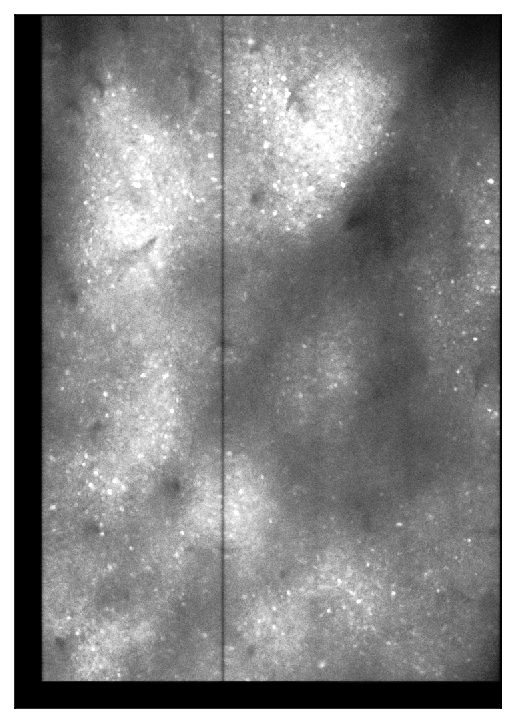

In [73]:
tfu.show_tif(im_full[0])

In [74]:
# job.params['cell_filt_type'] = 'gaussian'

# job.params['voxel_size_um'] = (20, 3.33, 3.33)
# job.params['npil_filt_xy_um'] = 70
# job.params['cell_filt_xy_um'] = 5
# job.params['sdnorm_exp'] = 0.80

# params_to_sweep = {
#     'cell_filt_xy_um' : (5,10),
#     'npil_filt_xy_um' : (40, 70, 100),
#     'sdnorm_exp' : (0.8,1.0),
# }
# job.sweep_corrmap(params_to_sweep, iter_limit=1)

In [75]:
job.params['cell_filt_type'] = 'gaussian'

job.params['voxel_size_um'] = (20, 3.33, 3.33)
job.params['npil_filt_xy_um'] = 70
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.80

In [76]:
%%time
corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/corrmap
   Updated main params file
   Computing correlation map of movie with 19378 frames, volume shape: 24, 1040, 730
      Running batch 1 of 97
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 97
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 97
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 4 of 97
         Load

In [77]:
res = job.load_corr_map_results()
vmap = res['vmap']

In [100]:
vmap = res['vmap']
pct50s = n.percentile(vmap, 50, axis=(1,2))
pct99p9s = n.percentile(vmap, 99.9, axis=(1,2))
vmap[0] -= (pct50s[0] - pct50s[1])

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f26cc0bd5e0>)

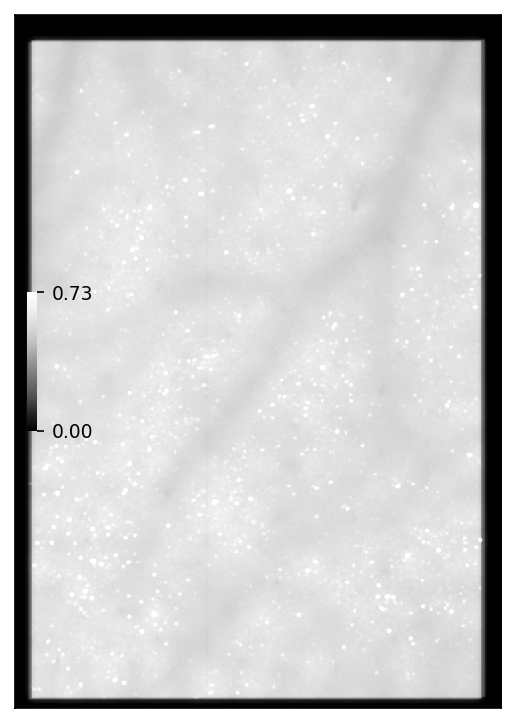

In [101]:
tfu.show_tif(vmap[17],cbar=True)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f26cc04f1c0>)

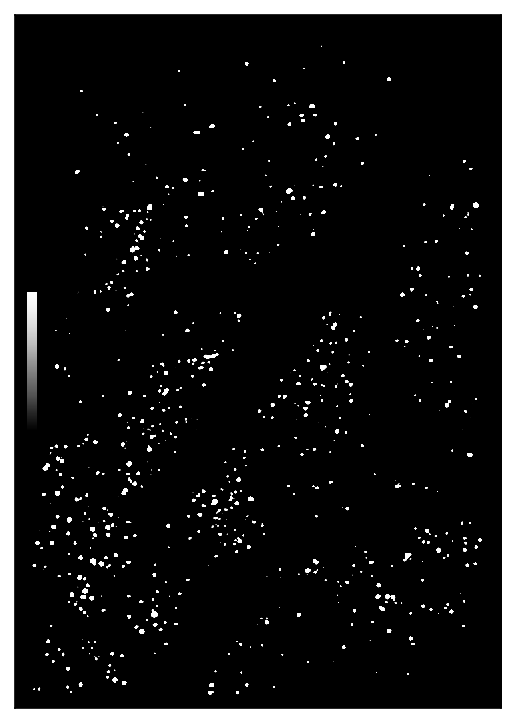

In [102]:
tfu.show_tif(vmap[17],cbar=True, vminmax=(0.65,0.66))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f26cbfd7ac0>)

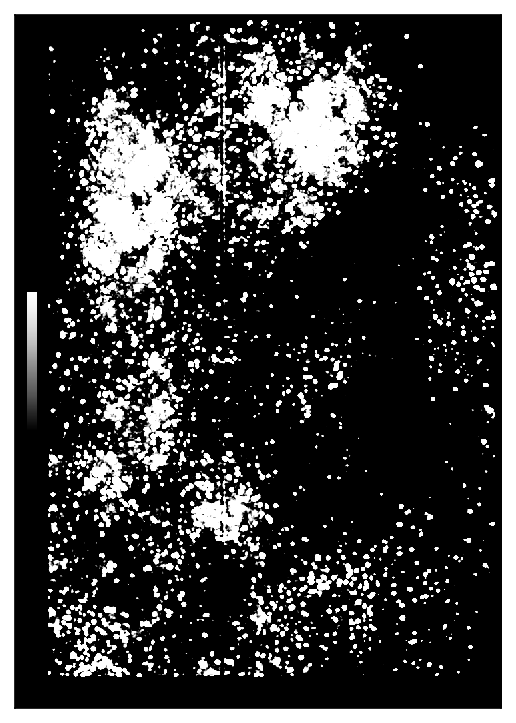

In [103]:
tfu.show_tif(vmap[0],cbar=True, vminmax=(0.65,0.66))

In [ ]:
job.params['peak_thresh'] = 0.66
job.params['percentile'] = 95.0

job.params['extend_thresh'] = 0.1
job.params['activity_thresh'] = 7.0
job.segment_rois(vmap=vmap)

   Created dir /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/segmentation with tag segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/segmentation
   Updated main params file
   Created dir /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois with tag rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/segmentation and /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 88
   Created dir /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/segmentation/patch-0000 with tag segmentation-patch-0000
         Loading 24.95 GB movie to memory, shape: (19378, 24, 120, 120) 


In [108]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])


'/mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois'

In [111]:

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])

   Updated main params file
   Movie shape: (24, 19378, 1040, 730)
60708
   Extracting 60708 valid cells, and saving cell flags to /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 39 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois
            Extracting batch 0000 of 0039
            Batch size: 33 GB
            Extracting batch 0001 of 0039
            Batch size: 33 GB
            Extracting batch 0002 of 0039
            Batch size: 33 GB
            Extracting batch 0003 of 0039
            Batch size: 33 GB
            Extracting batch 0004 of 0039
            Batch size: 33 GB
            Extracting batch 0005 of 0039
            Batch size: 33 GB
            Extracting batch 0006 of 0039
            Batch size: 33 GB
            Extracting batch 0007 of 0039
            Batch size: 33 GB
            Extracting batch 0008 of 0039
            Batch size: 33 GB
       

In [112]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')

   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-SS002_2024-08-19_1-2-3-4 to export results
      Loading from /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois/F.npy
      Loading from /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois/spks.npy
      Loading from /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois/Fneu.npy
      Loading from /mnt/md0/runs/s3d-SS002_2024-08-19_1-2-3-4/rois/iscell.npy
   /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00001.tif is 100 frames and 3971882544 bytes
   /mnt/zortex-subjects/SS002/2024-08-19/1/2024-08-19_1_SS002_2P_00001_00028.tif is 45 frames and 1787368784 bytes
   /mnt/zortex-subjects/SS002/2024-08-19/2/2024-08-19_2_SS002_2P_00001_00071.tif is 60 frames and 2383145264 bytes
   /mnt/zortex-subjects/SS002/2024-08-19/3/2024-08-19_3_SS002_2P_00001_00055.tif is 2 frames an